In [1]:
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

from sklearn import datasets

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(42)
x = 2*np.random.rand(100, 1)
y = 4 + 3*x+np.random.randn(100, 1)

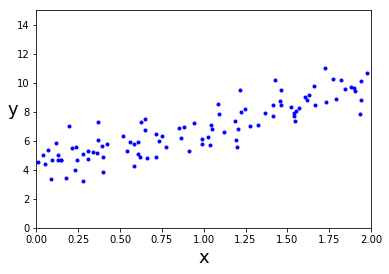

In [3]:
plt.plot(x, y, "b.")
plt.xlabel("x", fontsize=18)
plt.ylabel("y", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [4]:
x_b = np.c_[np.ones((100, 1)), x]
theta_hat = np.linalg.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y)

In [5]:
theta_hat

array([[4.21509616],
       [2.77011339]])

In [6]:
x_new = np.array([[0], [2]])
x_new_b = np.c_[np.ones((2, 1)), x_new]
y_predict = x_new_b.dot(theta_hat)

In [7]:
y_predict

array([[4.21509616],
       [9.75532293]])

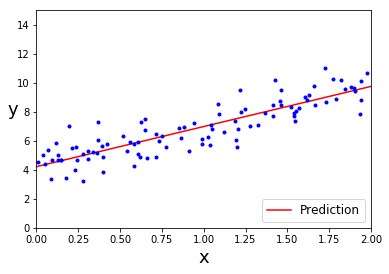

In [8]:
plt.plot(x_new, y_predict, "r-", label="Prediction")
plt.plot(x, y, "b.")
plt.xlabel("x", fontsize=18)
plt.ylabel("y", rotation=0, fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.axis([0, 2, 0, 15])
plt.show()

In [9]:
lin_reg = LinearRegression()
lin_reg.fit(x, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(x_new)

array([[4.21509616],
       [9.75532293]])

In [11]:
eta = 0.1
n_i = 1000
m = 100

theta = np.random.randn(2, 1)

for i in range(n_i):
    gradients = 2/m * x_b.T.dot(x_b.dot(theta) - y)
    theta = theta - eta*gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

In [13]:
x_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [14]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(x_b)
    plt.plot(x, y, "b.")
    n_i = 1000
    for i in range(n_i):
        if i < 10:
            y_predict = x_new_b.dot(theta)
            style = "r-" if i > 0 else "r--"
            plt.plot(x_new, y_predict, style)
        gradients = 2/m * x_b.T.dot(x_b.dot(theta) - y)
        theta = theta - eta*gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("x", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=18)

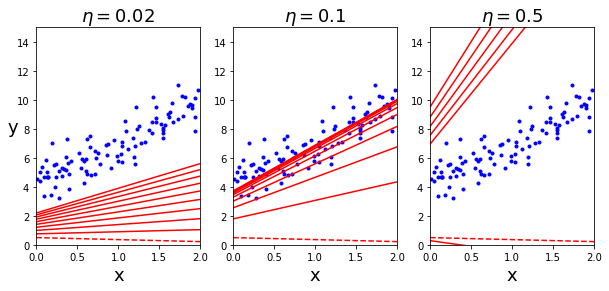

In [15]:
np.random.seed(42)
theta = np.random.randn(2, 1)

plt.figure(figsize=(10, 4))
plt.subplot(131); plot_gradient_descent(theta, eta = 0.02)
plt.ylabel("y", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta = 0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta = 0.5)

plt.show()

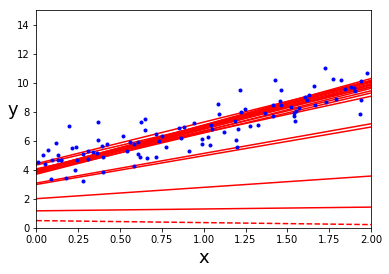

In [16]:
theta_path_sgd = []
m = len(x_b)

n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0/(t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = x_new_b.dot(theta)
            style = "r-" if i > 0 else "r--"
            plt.plot(x_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = x_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch*m + 1)
        theta = theta - eta*gradients
        theta_path_sgd.append(theta)
        
plt.plot(x, y, "b.")
plt.xlabel("x", fontsize=18)
plt.ylabel("y", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [17]:
theta

array([[4.21035883],
       [2.74821986]])

In [18]:
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty = None, eta0 = 0.1)
sgd_reg.fit(x, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=50,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=-inf, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.23166744]), array([2.79099659]))

In [20]:
theta_path_mgd = []

n_i = 50
minibatch_size = 20
t0, t1 = 200, 1000

np.random.seed(42)
theta = np.random.randn(2, 1)

def learning_schedule(t):
    return t0/(t + t1)

t = 0
for epoch in range(n_i):
    shuffled_indices = np.random.permutation(m)
    x_b_shuffled = x_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t+=1
        xi = x_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta*gradients
        theta_path_mgd.append(theta)

In [21]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [22]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

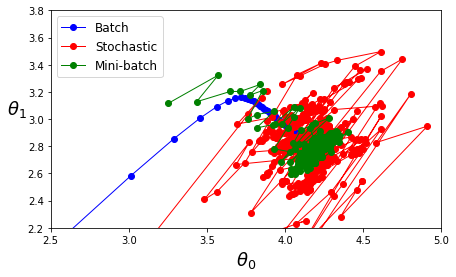

In [23]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=1, label="Batch")
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-o", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-o", linewidth=1, label="Mini-batch")
plt.legend(loc="upper left", fontsize=12)
plt.xlabel(r"$\theta_0$", fontsize=18)
plt.ylabel(r"$\theta_1$   ", fontsize=18, rotation=0)
plt.axis([2.5, 5, 2.2, 3.8])
plt.show()

In [24]:
np.random.seed(42)

m = 100
x = 6*np.random.rand(m, 1) - 3
y = 0.5*x**2 + x + 2 + np.random.randn(m, 1)

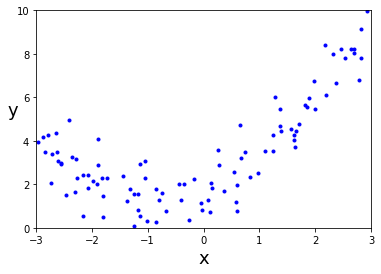

In [25]:
plt.plot(x, y, "b.")
plt.xlabel("x", fontsize=18)
plt.ylabel("y", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [26]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)
x[0]

array([-0.75275929])

In [27]:
x_poly[0]

array([-0.75275929,  0.56664654])

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

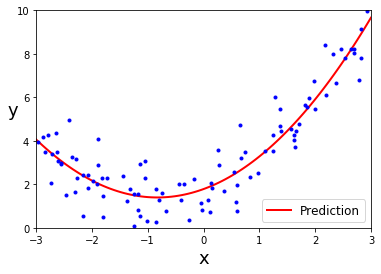

In [29]:
x_new = np.linspace(-3, 3, 100).reshape(100, 1)
x_new_poly = poly_features.fit_transform(x_new)
y_new = lin_reg.predict(x_new_poly)

plt.plot(x_new, y_new, "r-", linewidth=2, label="Prediction")
plt.plot(x, y, "b.")
plt.xlabel("x", fontsize=18)
plt.ylabel("y", rotation=0, fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.axis([-3, 3, 0, 10])
plt.show()

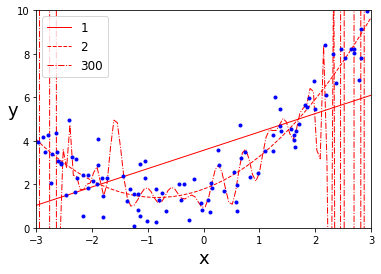

In [30]:
for style, width, degree in (("r-", 1, 1), ("r--", 1, 2), ("r-.", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(x, y)
    y_newbig = polynomial_regression.predict(x_new)
    plt.plot(x_new, y_newbig, style, label=str(degree), linewidth=width)
    
plt.plot(x, y, "b.")
plt.legend(loc="upper left", fontsize=12)
plt.xlabel("x", fontsize=18)
plt.ylabel("y", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [31]:
def plot_learning_curves(model, x, y):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(x_train)):
        model.fit(x_train[:m], y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-", linewidth=2, label="Training set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label="Validation set")
    plt.legend(loc="upper right", fontsize=12)
    plt.xlabel("Training set size", fontsize=18)
    plt.ylabel("RMSE", fontsize=18)
    plt.axis([0, 80, 0, 3])
    plt.show()

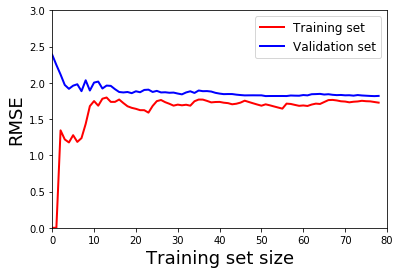

In [32]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, x, y)

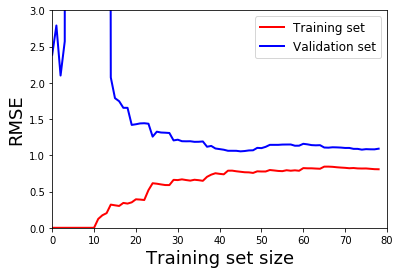

In [33]:
polynomial_regression = Pipeline((
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("sgd_reg", LinearRegression())
    ))

plot_learning_curves(polynomial_regression, x, y)

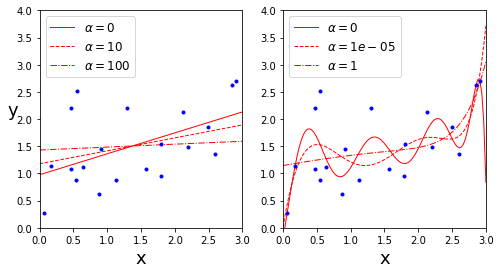

In [34]:
np.random.seed(42)

m = 20
x = 3*np.random.rand(m, 1)
y = 1 + 0.5*x + np.random.randn(m, 1)/1.5

x_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("r-", "r--", "r-.")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(x, y)
        y_new_regul = model.predict(x_new)
        lw = 1
        plt.plot(x_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(x, y, "b.")
    plt.legend(loc="upper left", fontsize=12)
    plt.xlabel("x", fontsize=18)
    plt.axis([0, 3, 0, 4])
    
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("y", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

In [35]:
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(x, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [36]:
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty="l2", random_state=42)
sgd_reg.fit(x, y.ravel())
sgd_reg.predict([[1.5]])

array([1.49905184])

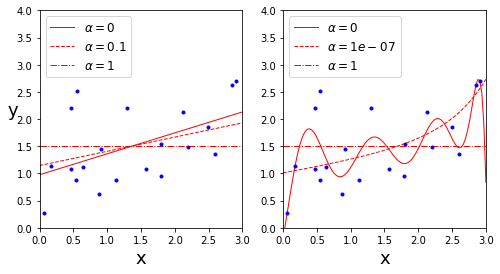

In [37]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("y", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

In [38]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(x, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [39]:
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(x, y)
elastic_net.predict([[1.5]])

array([1.54333232])

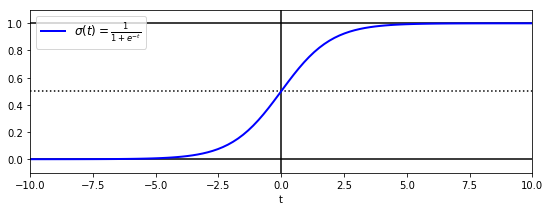

In [40]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k-")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=12)
plt.axis([-10, 10, -0.1, 1.1])

plt.show()

In [41]:
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [42]:
x = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

In [43]:
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

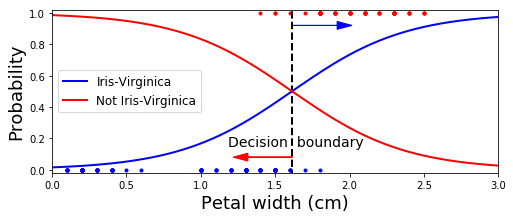

In [44]:
x_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_p = log_reg.predict_proba(x_new)

decision_boundary = x_new[y_p[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(x[y==0], y[y==0], "b.")
plt.plot(x[y==1], y[y==1], "r.")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k--", linewidth=2)
plt.plot(x_new, y_p[:, 1], "b-", linewidth=2, label="Iris-Virginica")
plt.plot(x_new, y_p[:, 0], "r-", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='r', ec='r')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.xlabel("Petal width (cm)", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.legend(loc="center left", fontsize=12)
plt.axis([0, 3, -0.02, 1.02])

plt.show()


In [45]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

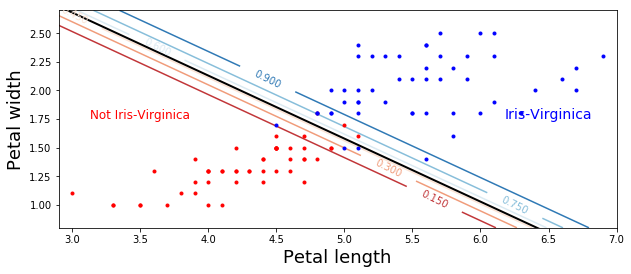

In [46]:
x = iris["data"][:, (2, 3)]
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="liblinear", C=10**10, random_state=42)
log_reg.fit(x, y)

x0, x1 = np.meshgrid(
         np.linspace(2.9, 7, 500).reshape(-1, 1),
         np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )

x_new = np.c_[x0.ravel(), x1.ravel()]

y_p = log_reg.predict_proba(x_new)

plt.figure(figsize=(10, 4))
plt.plot(x[y==0, 0], x[y==0, 1], "r.")
plt.plot(x[y==1, 0], x[y==1, 1], "b.")

zz = y_p[:, 1].reshape(x0.shape)

contour = plt.contour(x0, x1, zz, cmap = plt.cm.RdBu)

left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0]*left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=10)
plt.plot(left_right, boundary, "k-", linewidth=2)
plt.text(3.5, 1.75, "Not Iris-Virginica", fontsize=12, color="r", ha="center")
plt.text(6.5, 1.75, "Iris-Virginica", fontsize=14, color="b", ha="center")
plt.xlabel("Petal length", fontsize=18)
plt.ylabel("Petal width", fontsize=18)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

In [47]:
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg.fit(x, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
softmax_reg.predict([[5, 2]])

array([2])

In [49]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

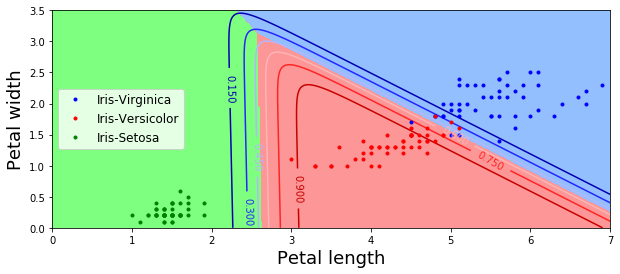

In [54]:
x0, x1 = np.meshgrid(
         np.linspace(0, 8, 500).reshape(-1, 1),
         np.linspace(0, 3.5, 200).reshape(-1, 1),
    )

x_new = np.c_[x0.ravel(), x1.ravel()]

y_prob = softmax_reg.predict_proba(x_new)
y_pred = softmax_reg.predict(x_new)

plt.figure(figsize=(10, 4))
plt.plot(x[y==2, 0], x[y==2, 1], "b.", label="Iris-Virginica")
plt.plot(x[y==1, 0], x[y==1, 1], "r.", label="Iris-Versicolor")
plt.plot(x[y==0, 0], x[y==0, 1], "g.", label="Iris-Setosa")

zz1 = y_prob[:, 1].reshape(x0.shape)
zz2 = y_pred.reshape(x0.shape)

custom_cmap = ListedColormap(['#7fff7f', '#fd9696', '#94bfff'])

plt.contourf(x0, x1, zz2, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.seismic)
plt.clabel(contour, inline=1, fontsize=10)
plt.xlabel("Petal length", fontsize=18)
plt.ylabel("Petal width", fontsize=18)
plt.legend(loc="center left", fontsize=12)
plt.axis([0, 7, 0, 3.5])

plt.show()